<a href="https://colab.research.google.com/github/saeedshahi/Portfolio/blob/main/Enhancing_Semiconductor_Fabrication/ML_Litho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Step 1: Prepare the Dataset and DataLoader

In [ ]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

class LithographyDataset(Dataset):
    def __init__(self, pattern_dir, mask_dir, transform=None):
        self.pattern_dir = pattern_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.patterns = [x for x in os.listdir(pattern_dir) if x.endswith('.png') or x.endswith('.jpg')]
        self.pattern_to_mask = {x: x.replace('.png', 'OPC.png').replace('.jpg', 'OPC.jpg') for x in self.patterns}

    def __len__(self):
        return len(self.patterns)

    def __getitem__(self, idx):
        pattern_filename = self.patterns[idx]
        mask_filename = self.pattern_to_mask[pattern_filename]
        pattern_path = os.path.join(self.pattern_dir, pattern_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        pattern = Image.open(pattern_path).convert('L')  # Convert to grayscale
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            pattern = self.transform(pattern)
            mask = self.transform(mask)

        return pattern, mask

pattern_dir = '/content/drive/MyDrive/Projects/ML_Litho/ganopc-data/target/images'
mask_dir    = '/content/drive/MyDrive/Projects/ML_Litho/ganopc-data/mask/images'

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])

# Initialize your dataset with this transformation
full_dataset = LithographyDataset(pattern_dir, mask_dir, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
test_size = val_size = int(0.1 * len(full_dataset))
remainder = len(full_dataset) - (train_size + test_size + val_size)
test_size += remainder  # Adjust test set size to account for rounding
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

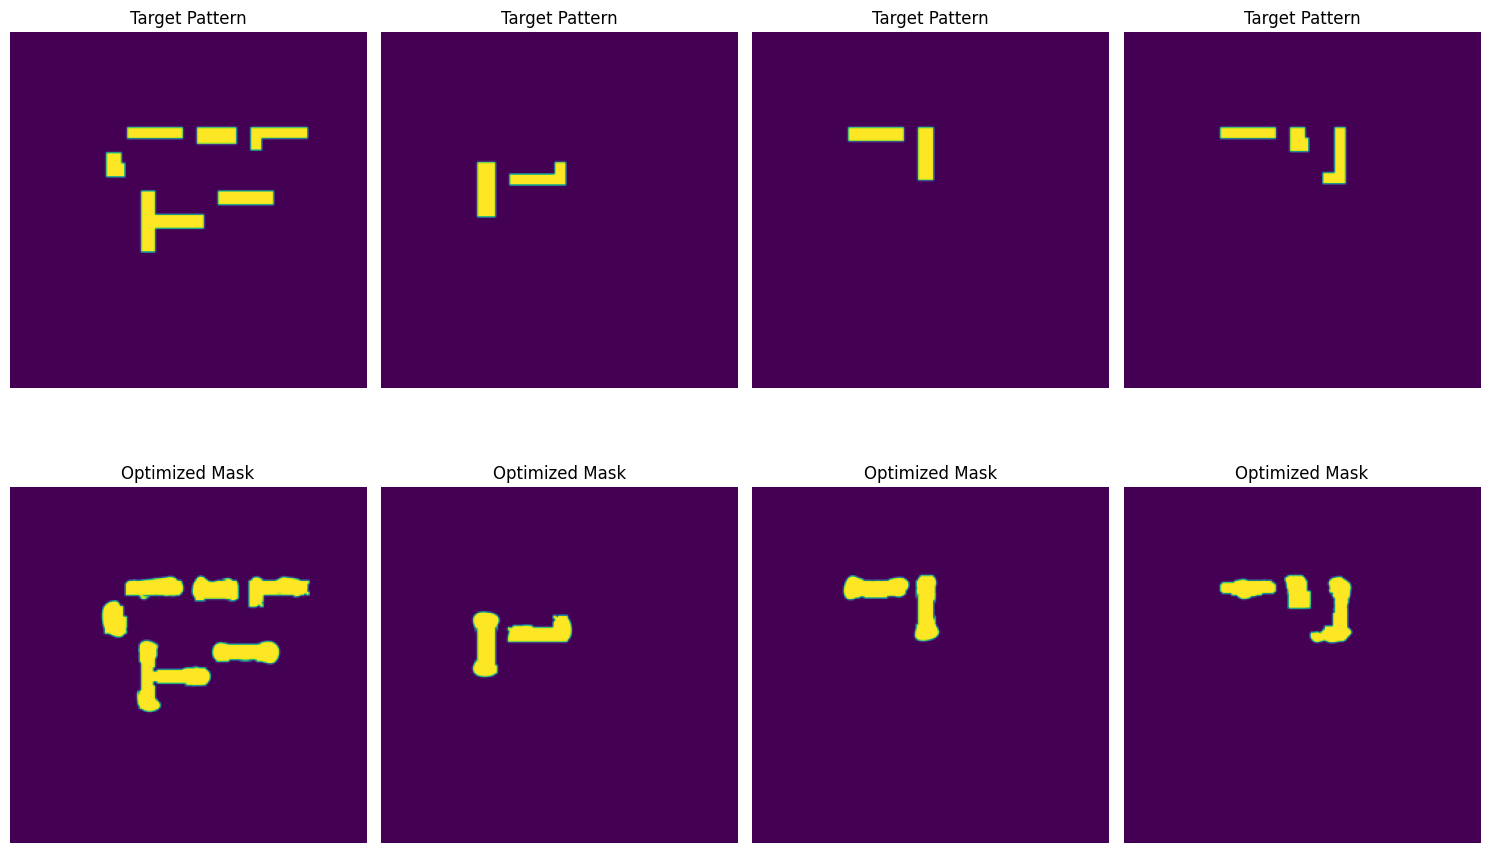

In [41]:
def plot_images_grid(images, titles, n_rows=3, n_cols=4, figsize=(15, 10)):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for row in range(n_rows):
        for col in range(n_cols):
            if col < len(images[row]):
                img = images[row][col].numpy().transpose((1, 2, 0))
                axs[row, col].imshow(img)
                axs[row, col].set_title(titles[row])
                axs[row, col].axis('off')
            else:
                axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

def visualize_batch(dataloader):
    dataiter = iter(dataloader)
    targets, masks = next(dataiter)
    n_display = min(4, len(masks))  # Display up to 4 images from the batch
    images_to_plot = [targets[:n_display], masks[:n_display]]
    titles = ['Target Pattern', 'Optimized Mask']
    plot_images_grid(images_to_plot, titles, n_rows=2, n_cols=n_display)

visualize_batch(train_loader)

# Step 2: Define the Model (UNet)

In [33]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = F.max_pool2d(x1, 2)
        x3 = self.down1(x2)
        x4 = F.max_pool2d(x3, 2)
        x5 = self.down2(x4)
        x6 = F.max_pool2d(x5, 2)
        x7 = self.down3(x6)
        x8 = F.max_pool2d(x7, 2)
        x9 = self.down4(x8)
        x = self.up1(x9)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        logits = self.outc(x)
        return logits

# Step 3: Training

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * inputs.size(0)

        train_loss = running_loss_train / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_loss_val = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)

        val_loss = running_loss_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered. Stopping training.')
                break

        scheduler.step()  # Update the learning rate

    model.load_state_dict(best_model_wts)
    return train_losses, val_losses

# Plotting the Learning Curve

In [35]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Run the model

In [36]:
from torch.optim.lr_scheduler import StepLR

model = UNet(n_channels=1, n_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)


# Plot the learning curve
plot_learning_curve(train_losses, val_losses)

Epoch 1/50, Train Loss: -1.2002, Validation Loss: -10.6252
Epoch 2/50, Train Loss: -133.0549, Validation Loss: -475.0137


KeyboardInterrupt: 

# Save the model

In [ ]:
model_path = '/content/drive/MyDrive/Projects/ML_Litho/unet_lithography_model.pth'
torch.save(model.state_dict(), model_path)

# Evaluation

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    print(f'Test Loss (L2 Metric): {total_loss / len(test_loader.dataset):.4f}')

evaluate_model(model, test_loader, nn.MSELoss())

# Generate and Compare Optimized Masks

In [ ]:
def compare_masks(model, dataset, idx):
    model.eval()
    pattern, real_mask = dataset[idx]
    pattern.unsqueeze_(0)  # Add batch dimension
    with torch.no_grad():
        optimized_mask = model(pattern)
    pattern.squeeze_(0)  # Remove batch dimension for plotting
    optimized_mask.squeeze_(0)  # Remove batch dimension for plotting

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(pattern.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[0].set_title('Original Pattern')
    axes[1].imshow(real_mask.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
    axes[1].set_title('Real Optimized Mask')
    axes[2].imshow(optimized_mask.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
    axes[2].set_title('Predicted Optimized Mask')
    plt.show()

compare_masks(model, test_dataset, idx=0)